<div style="display: flex; justify-content: center; margin-bottom: 20px;">
  <img src="../docs/_static/seispolarity_logo_title.svg">
</div>

---

# SeisPolarity Prediction API

This notebook demonstrates how to use SeisPolarity's unified prediction interface to perform polarity prediction on seismic waveforms.

## Features
- **Unified Interface**: Single `Predictor` class for all models
- **Automatic Download**: Models and datasets can be downloaded automatically
- **Multiple Models**: Support for ROSS, EQPolarity, DiTingMotion, APP, CFM, PolarCAP, RPNet
- **Flexible Input**: Support for various waveform lengths and formats
- **Comprehensive Metrics**: Confusion matrix, accuracy, and classification report

## List Available Pretrained Models

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from seispolarity.inference import Predictor

# List all available pretrained models with details
models = Predictor.list_pretrained(details=True)

Available pretrained models:

ROSS_SCSN:
  Filename: ROSS_SCSN.pth
  Input Length: 400
  Classes: 3 (Up, Down, Unknown)
  Description: ROSS model: Ross, Z. E., Meier, M. & Hauksson, E. P Wave Arrival Picking and First-Motion Polarity Determination With Deep Learning. JGR Solid Earth 123, 5120-5129 (2018) . Trained on SCSN dataset. 3-class classification (Up, Down, Unknown). Input length: 400 samples.
  Author: Model weights converted and maintained by He XingChen (Chinese, Han ethnicity), `https://github.com/Chuan1937`
-------------------------------------------------------

ROSS_GLOBAL:
  Filename: ROSS_GLOBAL.pth
  Input Length: 400
  Classes: 3 (Up, Down, Unknown)
  Description: ROSS model: Ross, Z. E., Meier, M. & Hauksson, E. P Wave Arrival Picking and First-Motion Polarity Determination With Deep Learning. JGR Solid Earth 123, 5120-5129 (2018) . Trained on global datasets: SCSN , INSTANCE: Michelini, A. et al. INSTANCE-the Italian seismic dataset for machine learning. Earth Syste

## Configuration

In [ ]:
import torch

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Model selection
MODEL_NAME = "ROSS_SCSN"  # Options: ROSS_SCSN, ROSS_GLOBAL, EQPOLARITY_SCSN, etc.

# Dataset configuration
CROP_LEFT = 200  
CROP_RIGHT = 200  
BATCH_SIZE = 2048
PRELOAD = True
ALLOWED_LABELS = [0, 1, 2]  # 0=Up, 1=Down, 2=Unknown

print(f"Device: {DEVICE}")
print(f"Model: {MODEL_NAME}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Preload data: {PRELOAD}")

Device: cuda
Model: ROSS_SCSN
Batch size: 2048
Preload data: True


## Load Dataset

You can either use a local dataset file or download the dataset automatically.

In [3]:
# Option 1: Use local dataset file
TEST_FILE = "/mnt/f/AI_Seismic_Data/scsn/scsn_p_2000_2017_6sec_0.5r_fm_test.hdf5"

# Option 2: Use automatic download (uncomment to use)
# from seispolarity.data import SCSNData
# scsn_processor = SCSNData(output_dir="./datasets")
# TEST_FILE = scsn_processor.download()
# print(TEST_FILE)

# For this example, we'll use a placeholder path
# Replace this with your actual dataset path
print(f"Dataset path: {TEST_FILE}")

Dataset path: /mnt/f/AI_Seismic_Data/scsn/scsn_p_2000_2017_6sec_0.5r_fm_test.hdf5


## Create WaveformDataset

In [ ]:
from seispolarity.data import WaveformDataset

dataset = WaveformDataset(
    path=TEST_FILE,
    name="SCSN_Test",
    preload=PRELOAD,
    allowed_labels=ALLOWED_LABELS,
    data_key="X",
    label_key="Y",
    clarity_key=None,
    pick_key=None,  
    metadata_keys=[], 
    p_pick_position=300,     
    crop_left=CROP_LEFT,      
    crop_right=CROP_RIGHT     
)

print(f"Dataset created: {dataset._name}")
print(f"Dataset length: {len(dataset)}")
print(f"Allowed labels: {dataset.allowed_labels}")

2026-02-07 11:14:04,269 - seispolarity.data - INFO - Initialized Flat Dataset from scsn_p_2000_2017_6sec_0.5r_fm_test.hdf5 with 2353054 samples.
2026-02-07 11:14:04,269 | seispolarity.data | INFO | Initialized Flat Dataset from scsn_p_2000_2017_6sec_0.5r_fm_test.hdf5 with 2353054 samples.
2026-02-07 11:14:04,294 - seispolarity.data - INFO - Built index with 2353054 samples (filtered from 2353054)
2026-02-07 11:14:04,294 | seispolarity.data | INFO | Built index with 2353054 samples (filtered from 2353054)
2026-02-07 11:14:04,299 - seispolarity.data - INFO - Loading 2353054 samples into RAM...
2026-02-07 11:14:04,299 | seispolarity.data | INFO | Loading 2353054 samples into RAM...
2026-02-07 11:14:04,303 - seispolarity.data - INFO - Loading Metadata...
2026-02-07 11:14:04,303 | seispolarity.data | INFO | Loading Metadata...
Loading RAM: 100%|██████████| 2353054/2353054 [00:20<00:00, 115924.25samples/s]
2026-02-07 11:14:24,614 - seispolarity.data - INFO - RAM Load Complete.
2026-02-07 11:

Dataset created: SCSN_Test
Dataset length: 2353054
Allowed labels: [0, 1, 2]


## Initialize Predictor

In [5]:
# Initialize predictor
# The model will be automatically downloaded from Hugging Face or ModelScope
predictor = Predictor(
    model_name=MODEL_NAME,
    device=DEVICE
)

# Alternatively, load model from local path
# predictor = Predictor(
#     model_name=MODEL_NAME,
#     model_path="/path/to/local/model.pth",
#     device=DEVICE
# )

print(f"Predictor initialized")
print(f"Model config: {predictor.config_key}")
print(f"Input length: {predictor.config['input_len']}")
print(f"Number of classes: {predictor.config['num_classes']}")
print(f"Class mapping: {predictor.config['class_map']}")

# Use the unified WaveformDataset interface
loader = dataset.get_dataloader(
    batch_size=BATCH_SIZE,  
    num_workers=4 if not PRELOAD else 0, 
    shuffle=False
)

print(f"DataLoader created")
print(f"Number of batches: {len(loader)}")

Using model: ROSS_SCSN (ROSS_SCSN)
Using device: cuda
Checking for model 'ROSS_SCSN.pth' in ./checkpoints_download...
Hugging Face network is not accessible, will use ModelScope.
Attempting download from ModelScope...


2026-02-07 11:14:43,960 - seispolarity.data - INFO - DataLoader: batch=2048, workers=0, shuffle=False, preload=True
2026-02-07 11:14:43,960 | seispolarity.data | INFO | DataLoader: batch=2048, workers=0, shuffle=False, preload=True


Model loaded from ModelScope: ./checkpoints_download/chuanjun/HeXingChen/ROSS/ROSS_SCSN.pth
Weights loaded successfully (strict mode).
Predictor initialized
Model config: ROSS_SCSN
Input length: 400
Number of classes: 3
Class mapping: {0: 'Up', 1: 'Down', 2: 'Unknown'}
DataLoader created
Number of batches: 1149


## Perform Prediction

In [6]:
import numpy as np

# Predict from dataloader
probabilities, labels = predictor.predict_from_loader(loader, return_probs=True)

# Get predictions (argmax of probabilities)
predictions = np.argmax(probabilities, axis=1)

print(f"Prediction completed")
print(f"Number of samples: {len(predictions)}")
print(f"Prediction shape: {predictions.shape}")
print(f"Probability shape: {probabilities.shape}")

Predicting: 100%|██████████| 1149/1149 [00:36<00:00, 31.32batch/s]

Prediction completed
Number of samples: 2353054
Prediction shape: (2353054,)
Probability shape: (2353054, 3)


## Evaluate Results


Confusion Matrix

Confusion Matrix (sample counts):
True\Pred | 0 (Up) | 1 (Down) | 2 (Unknown)
--------------------------------------------------
      0 (Up)     |  498877 |    8403 |   78738 |
      1 (Down)     |    4012 |  246121 |   27000 |
      2 (Unknown)     |  230816 |  213517 | 1045570 |


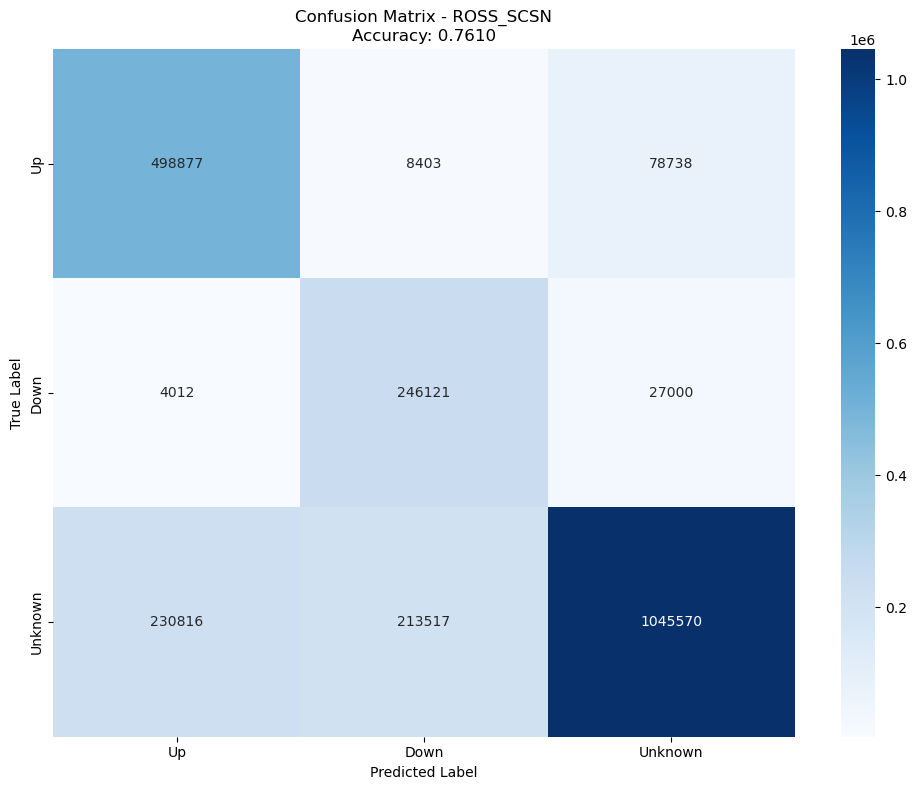

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(labels, predictions)

print("\n" + "="*60)
print("Confusion Matrix")
print("="*60)

# Print numerical confusion matrix
print(f"\nConfusion Matrix (sample counts):")
print(f"True\\Pred | 0 (Up) | 1 (Down) | 2 (Unknown)")
print("-" * 50)
for i in range(3):
    label_name = ['Up', 'Down', 'Unknown'][i]
    row_str = f"      {i} ({label_name})     |"
    for j in range(3):
        row_str += f" {cm[i, j]:7d} |"
    print(row_str)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Up', 'Down', 'Unknown'],
            yticklabels=['Up', 'Down', 'Unknown'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - {MODEL_NAME}\nAccuracy: {accuracy:.4f}')
plt.tight_layout()
plt.show()

## Using Different Models

You can easily switch between different pretrained models by changing the `MODEL_NAME` parameter:

In [12]:
# Examples of using different models

# ROSS model (3-class: Up, Down, Unknown)
# predictor_ross = Predictor("ROSS_SCSN", device=DEVICE)

# EQPolarity model (2-class: Up, Down)
# predictor_eq = Predictor("EQPOLARITY_SCSN", device=DEVICE)

# DiTingMotion model (3-class: Up, Down, Unknown)
# predictor_diting = Predictor("DITINGMOTION_DITINGSCSN", device=DEVICE)

# APP model (3-class: Up, Down, Unknown)
# predictor_app = Predictor("APP_SCSN", device=DEVICE)

# CFM model (2-class: Up, Down)
# predictor_cfm = Predictor("CFM_SCSN", device=DEVICE)

# PolarCAP model (2-class: Up, Down)
# predictor_polarcap = Predictor("POLARCAP_SCSN", device=DEVICE)

# RPNet model (2-class: Up, Down)
# predictor_rpnet = Predictor("RPNET_SCSN", device=DEVICE)

# Global models (trained on multiple datasets)
# predictor_global = Predictor("ROSS_GLOBAL", device=DEVICE)

print("See above examples for different model initialization")
print("Use Predictor.list_pretrained(details=True) to see all available models")

See above examples for different model initialization
Use Predictor.list_pretrained(details=True) to see all available models
